In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

os.environ['CLMM_MODELING_BACKEND'] = 'ccl' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)

import clmm
from clmm import Cosmology
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from scipy.special import gamma, gammainc

import timeit


cosmo = Cosmology(H0=70.0, Omega_dm0=0.3-0.045, Omega_b0=0.045, Omega_k0=0.0)

# Individual profile

In [2]:
moo = clmm.Modeling(massdef='mean', delta_mdef=200, halo_profile_model='nfw')

moo.set_cosmo(cosmo)
moo.set_concentration(5)
moo.set_mass(1.e14)

z_cl = 0.1

# for the CCL backend
alpha_ein = 0.25
if moo.halo_profile_model == 'einasto':
    moo.set_einasto_alpha(alpha_ein)

## Original implementation

In [3]:
def R_from_true(theta, R, Roff):
    return np.sqrt(R*R + Roff*Roff - 2*R*Roff*np.cos(theta))

def integrand1(theta, R, Roff):
    return moo.eval_surface_density(R_from_true(theta, R, Roff), z_cl)/(2*np.pi)

# Sigma exact
def Sigma_mis_exact(R, Roff):
    return integrate.quad_vec(integrand1, 0., 2*np.pi, args=(R, Roff), epsrel=1e-6)[0]

# Sigma mean exact
def integrand_Sigmamean_exact(Rprime, Roff):
    return Rprime * Sigma_mis_exact(Rprime, Roff)

## Optimized implementation + backend independant

In [4]:
def integrand1_opt(theta, R, Roff):
    return moo.eval_surface_density(R_from_true(theta, R, Roff), z_cl)

c200 = moo.cdelta
rho_def = moo.cosmo.get_rho_m(z_cl)
r_s = moo.eval_rdelta(z_cl) / c200
rho_s_nfw = moo.delta_mdef/3.*c200**3.*rho_def/(np.log(1.+c200)-c200/(1.+c200))
rho_s_ein = moo.delta_mdef/3.*c200**3.*rho_def/(2.**(-3./alpha_ein) * alpha_ein**(-1.+3./alpha_ein) * np.exp(2./alpha_ein) * gamma(3./alpha_ein) * gammainc(3./alpha_ein, 2./alpha_ein*c200**alpha_ein))
rho_s_her = moo.delta_mdef/3.*c200**3.*rho_def/((c200/(1. + c200))**2.)*2

# can do the same for the Hernquist profile too
def integrand1_opt_nfw(theta, R, Roff):
    x = np.sqrt(R**2. + Roff**2. - 2.*R*Roff*np.cos(theta)) / r_s
    x2m1 = x**2. - 1.
    if x < 1:
        sqrt_x2m1 = np.sqrt(-x2m1)
        res = np.arcsinh(sqrt_x2m1/x) / (-x2m1)**(3./2.) + 1./x2m1
    elif x > 1:
        sqrt_x2m1 = np.sqrt(x2m1)
        res = -np.arcsin(sqrt_x2m1/x) / (x2m1)**(3./2.) + 1./x2m1
    else:
        res = 1./3.
    res *= 2. * r_s * rho_s_nfw
    return res

def integrand1_opt_ein(theta, R, Roff):
    def integrand0(z):
        x = np.sqrt(z**2. + R**2. + Roff**2. - 2.*R*Roff*np.cos(theta)) / r_s
        return np.exp(-2. * (x**alpha_ein - 1.) / alpha_ein)
    return integrate.quad_vec(integrand0, 0., np.inf)[0] * 2. * rho_s_ein

def integrand1_opt_her(theta, R, Roff):
    x = np.sqrt(R**2. + Roff**2. - 2.*R*Roff*np.cos(theta)) / r_s
    x2m1 = x**2. - 1.
    if x < 1:
        sqrt_x2m1 = np.sqrt(-x2m1)
        res = (-3 / x2m1**2
               + (x2m1+3) * np.arcsinh(sqrt_x2m1/x) / (-x2m1)**2.5)
    elif x > 1:
        sqrt_x2m1 = np.sqrt(x2m1)
        res = (-3 / x2m1**2
               + (x2m1+3) * np.arcsin(sqrt_x2m1/x) / (x2m1)**2.5)
    else:
        res = 4./15.
    res *= r_s * rho_s_her
    return res

# Sigma exact
def Sigma_mis_exact_opt(R, Roff):
    return integrate.quad_vec(integrand1_opt, 0., np.pi, args=(R, Roff), epsrel=1e-6)[0]/np.pi

def Sigma_mis_exact_opt_nfw(R, Roff):
    return integrate.quad_vec(integrand1_opt_nfw, 0., np.pi, args=(R, Roff))[0]/np.pi

def Sigma_mis_exact_opt_ein(R, Roff):
    return integrate.quad_vec(integrand1_opt_ein, 0., np.pi, args=(R, Roff))[0]/np.pi

def Sigma_mis_exact_opt_her(R, Roff):
    return integrate.quad_vec(integrand1_opt_her, 0., np.pi, args=(R, Roff), epsrel=1e-6)[0]/np.pi

# Sigma mean exact
def integrand_Sigmamean_exact_opt(Rprime, Roff):
    return Rprime * Sigma_mis_exact_opt(Rprime, Roff)

def integrand_Sigmamean_exact_opt_nfw(Rprime, Roff):
    return Rprime * Sigma_mis_exact_opt_nfw(Rprime, Roff)

def integrand_Sigmamean_exact_opt_ein(Rprime, Roff):
    return Rprime * Sigma_mis_exact_opt_ein(Rprime, Roff)

def integrand_Sigmamean_exact_opt_her(Rprime, Roff):
    return Rprime * Sigma_mis_exact_opt_her(Rprime, Roff)

In [5]:
def Sigma_mean_mis_exact(R_arr, Roff):
    res=[]
    for i,R in enumerate(R_arr):
        res.append(integrate.quad(integrand_Sigmamean_exact, 0., R, args=(Roff))[0]*2./R/R)
    return np.array(res)

def Sigma_mean_mis_exact_opt(R_arr, Roff):
    res = np.zeros_like(R_arr)
    for i, R in enumerate(R_arr):
        R_lower = 0 if i==0 else R_arr[i-1]
        res[i] = integrate.quad(integrand_Sigmamean_exact_opt, R_lower, R, args=(Roff))[0]
    res = np.cumsum(res)*2/R_arr**2
    return res

def Sigma_mean_mis_exact_opt_nfw(R_arr, Roff):
    res = np.zeros_like(R_arr)
    for i, R in enumerate(R_arr):
        R_lower = 0 if i==0 else R_arr[i-1]
        res[i] = integrate.quad(integrand_Sigmamean_exact_opt_nfw, R_lower, R, args=(Roff))[0]
    res = np.cumsum(res)*2/R_arr**2
    return res

def Sigma_mean_mis_exact_opt_ein(R_arr, Roff):
    res = np.zeros_like(R_arr)
    for i, R in enumerate(R_arr):
        R_lower = 0 if i==0 else R_arr[i-1]
        res[i] = integrate.quad(integrand_Sigmamean_exact_opt_ein, R_lower, R, args=(Roff))[0]
    res = np.cumsum(res)*2/R_arr**2
    return res

def Sigma_mean_mis_exact_opt_her(R_arr, Roff):
    res = np.zeros_like(R_arr)
    for i, R in enumerate(R_arr):
        R_lower = 0 if i==0 else R_arr[i-1]
        res[i] = integrate.quad(integrand_Sigmamean_exact_opt_her, R_lower, R, args=(Roff))[0]
    res = np.cumsum(res)*2/R_arr**2
    return res

def Sigma_mean_mis_trap(R_arr, Roff, regrid=10):
    # use finer grid that R_arr to evaluate integral, for precision purpose. Controld by the regrid parameter. 
    new_R_arr = np.logspace(np.log10(1.e-5), np.log10(R_arr.max()), regrid)

    res = (2./new_R_arr**2) * integrate.cumulative_trapezoid(new_R_arr * Sigma_mis_exact(new_R_arr, Roff), new_R_arr, initial=0)

    f = interp1d(new_R_arr, res)
    return f(R_arr)

## Use dblquad for Sigma_mean

In [6]:
def integrand_dbl_opt(Rp, theta, Roff):
    return Rp * integrand1_opt(theta, Rp, Roff)

def integrand_dbl_opt_nfw(Rp, theta, Roff):
    return Rp * integrand1_opt_nfw(theta, Rp, Roff)

def integrand_tpl_opt_ein(Rp, z, theta, Roff):
    x = np.sqrt(z**2. + Rp**2. + Roff**2. - 2.*Rp*Roff*np.cos(theta)) / r_s
    return Rp * np.exp(-2. * (x**alpha_ein - 1.) / alpha_ein)
    #return Rp * integrand1_opt_ein(theta, Rp, Roff)

def integrand_dbl_opt_ein(Rp, theta, Roff):
    return Rp * integrand1_opt_ein(theta, Rp, Roff)

def integrand_dbl_opt_her(Rp, theta, Roff):
    return Rp * integrand1_opt_her(theta, Rp, Roff)

def Sigma_mean_mis_exact_opt_dbl(R_arr, Roff):
    res = np.zeros_like(R_arr)
    for i, R in enumerate(R_arr):
        R_lower = 0 if i==0 else R_arr[i-1]
        res[i] = integrate.dblquad(integrand_dbl_opt, 0, np.pi, R_lower, R, args=[Roff], epsrel=1.e-6)[0]
    res = np.cumsum(res)*2/R_arr**2/np.pi
    return res

def Sigma_mean_mis_exact_opt_nfw_dbl(R_arr, Roff):
    res = np.zeros_like(R_arr)
    for i, R in enumerate(R_arr):
        R_lower = 0 if i==0 else R_arr[i-1]
        res[i] = integrate.dblquad(integrand_dbl_opt_nfw, 0, np.pi, R_lower, R, args=[Roff])[0]
    res = np.cumsum(res)*2/R_arr**2/np.pi
    return res

def Sigma_mean_mis_exact_opt_ein_tpl(R_arr, Roff):
    res = np.zeros_like(R_arr)
    for i, R in enumerate(R_arr):
        R_lower = 0 if i==0 else R_arr[i-1]
        res[i] = integrate.tplquad(integrand_tpl_opt_ein, 0, np.pi, 0, np.inf, R_lower, R, args=[Roff])[0]
    res = np.cumsum(res)*2/R_arr**2/np.pi * 2. * rho_s_ein
    return res

def Sigma_mean_mis_exact_opt_ein_dbl(R_arr, Roff):
    res = np.zeros_like(R_arr)
    for i, R in enumerate(R_arr):
        R_lower = 0 if i==0 else R_arr[i-1]
        res[i] = integrate.dblquad(integrand_dbl_opt_ein, 0, np.pi, R_lower, R, args=[Roff])[0]
    res = np.cumsum(res)*2/R_arr**2/np.pi
    return res

def Sigma_mean_mis_exact_opt_her_dbl(R_arr, Roff):
    res = np.zeros_like(R_arr)
    for i, R in enumerate(R_arr):
        R_lower = 0 if i==0 else R_arr[i-1]
        res[i] = integrate.dblquad(integrand_dbl_opt_her, 0, np.pi, R_lower, R, args=[Roff])[0]
    res = np.cumsum(res)*2/R_arr**2/np.pi
    return res

## Dsig for all variants

In [7]:
def DS_mis_approx(R_arr, Roff, regrid=1000):
    return Sigma_mean_mis_trap(R_arr, Roff, regrid=regrid) - Sigma_mis_exact(R_arr, Roff)

def DS_mis_exact(R_arr, Roff):
    return Sigma_mean_mis_exact(R_arr, Roff) - Sigma_mis_exact(R_arr, Roff)

def DS_mis_exact_opt(R_arr, Roff):
    return Sigma_mean_mis_exact_opt(R_arr, Roff) - Sigma_mis_exact_opt(R_arr, Roff)

def DS_mis_exact_opt_nfw(R_arr, Roff):
    return Sigma_mean_mis_exact_opt_nfw(R_arr, Roff) - np.array([Sigma_mis_exact_opt_nfw(R_, Roff) for R_ in R_arr])

def DS_mis_exact_opt_ein(R_arr, Roff):
    return Sigma_mean_mis_exact_opt_ein(R_arr, Roff) - Sigma_mis_exact_opt_ein(R_arr, Roff)

def DS_mis_exact_opt_her(R_arr, Roff):
    return Sigma_mean_mis_exact_opt_her(R_arr, Roff) - np.array([Sigma_mis_exact_opt_her(R_, Roff) for R_ in R_arr])

def DS_mis_exact_opt_dbl(R_arr, Roff):
    return Sigma_mean_mis_exact_opt_dbl(R_arr, Roff) - np.array([Sigma_mis_exact_opt(R_, Roff) for R_ in R_arr])

def DS_mis_exact_opt_nfw_dbl(R_arr, Roff):
    return Sigma_mean_mis_exact_opt_nfw_dbl(R_arr, Roff) - np.array([Sigma_mis_exact_opt_nfw(R_, Roff) for R_ in R_arr])

def DS_mis_exact_opt_ein_dbl(R_arr, Roff):
    return Sigma_mean_mis_exact_opt_ein_dbl(R_arr, Roff) - np.array([Sigma_mis_exact_opt_ein(R_, Roff) for R_ in R_arr])

def DS_mis_exact_opt_ein_tpl(R_arr, Roff):
    return Sigma_mean_mis_exact_opt_ein_tpl(R_arr, Roff) - np.array([Sigma_mis_exact_opt_ein(R_, Roff) for R_ in R_arr])

def DS_mis_exact_opt_her_dbl(R_arr, Roff):
    return Sigma_mean_mis_exact_opt_her_dbl(R_arr, Roff) - np.array([Sigma_mis_exact_opt_her(R_, Roff) for R_ in R_arr])

## Speed and precision tests

In [8]:
Roff = 0.2
R_arr = np.logspace(-2, 1, 50)

### Sigma opt with ccl backend, NFW

In [9]:
%%time
Sigma_mis = Sigma_mis_exact_opt(R_arr, Roff)

CPU times: user 52 ms, sys: 10.1 ms, total: 62.1 ms
Wall time: 58.2 ms


### DeltaSigma for original implementation, ccl+NFW

In [ ]:
%%time
DeltaSigma_mis_exact = DS_mis_exact(R_arr, Roff)
# won't finish (or takes very long) for CCL Einasto

### DeltaSigma optimized, ccl+NFW

In [11]:
%%time
DeltaSigma_mis_exact_opt = DS_mis_exact_opt(R_arr, Roff)
# won't finish (or takes very long) for CCL Einasto

CPU times: user 36.6 s, sys: 702 ms, total: 37.3 s
Wall time: 37.8 s


Same but with doublequad for DeltaSigma

In [12]:
%%time
DeltaSigma_mis_dbl = DS_mis_exact_opt_dbl(R_arr, Roff)

CPU times: user 5.96 s, sys: 106 ms, total: 6.07 s
Wall time: 6.19 s


### Backend independant optimization

For **NFW** profile

In [13]:
%%time
DeltaSigma_mis_exact_opt_nfw = DS_mis_exact_opt_nfw(R_arr, Roff)

CPU times: user 1.73 s, sys: 35.2 ms, total: 1.76 s
Wall time: 1.79 s


For **NFW** profile + **dblquad** for DeltaSigma

In [14]:
%%time
DeltaSigma_mis_exact_opt_nfw_dbl = DS_mis_exact_opt_nfw_dbl(R_arr, Roff)

CPU times: user 286 ms, sys: 7.02 ms, total: 293 ms
Wall time: 294 ms


For **Hernquist** profile

In [15]:
%%time
DeltaSigma_mis_exact_opt_her = DS_mis_exact_opt_her(R_arr, Roff)

CPU times: user 1.69 s, sys: 36.3 ms, total: 1.72 s
Wall time: 1.72 s


For **Hernquist** profile + **dblquad** for DeltaSigma

In [16]:
%%time
DeltaSigma_mis_exact_opt_her_dbl = DS_mis_exact_opt_her_dbl(R_arr, Roff)

CPU times: user 299 ms, sys: 7 ms, total: 306 ms
Wall time: 307 ms


For **Einasto** profile

In [17]:
%%time
DeltaSigma_mis_exact_opt_ein = DS_mis_exact_opt_ein(R_arr, Roff)

CPU times: user 2min 54s, sys: 4.08 s, total: 2min 58s
Wall time: 3min 2s


For **Einasto** profile + **dblquad** for DeltaSigma

In [18]:
%%time
DeltaSigma_mis_exact_opt_ein_dbl = DS_mis_exact_opt_ein_dbl(R_arr, Roff)

CPU times: user 56.9 s, sys: 1.57 s, total: 58.5 s
Wall time: 59.4 s


For **Einasto** profile + **tplquad** for DeltaSigma

In [19]:
%%time
DeltaSigma_mis_exact_opt_ein_tpl = DS_mis_exact_opt_ein_tpl(R_arr, Roff)

CPU times: user 14.8 s, sys: 219 ms, total: 15.1 s
Wall time: 15.1 s


In [20]:
%%time
DeltaSigma_mis_1e2 = DS_mis_approx(R_arr, Roff, regrid=100)

CPU times: user 213 ms, sys: 15.6 ms, total: 229 ms
Wall time: 226 ms


In [21]:
%%time
DeltaSigma_mis_1e3 = DS_mis_approx(R_arr, Roff, regrid=1000)

CPU times: user 263 ms, sys: 7.69 ms, total: 271 ms
Wall time: 273 ms


In [22]:
%%time
DeltaSigma_mis_1e4 = DS_mis_approx(R_arr, Roff, regrid=10000)

CPU times: user 990 ms, sys: 55.2 ms, total: 1.05 s
Wall time: 1.05 s


In [23]:
%%time
Delta_Sigma_mis_ein_dbl = DS_mis_exact_opt_ein_dbl(R_arr, Roff)

CPU times: user 55.2 s, sys: 932 ms, total: 56.1 s
Wall time: 56.5 s


In [24]:
%%time
Delta_Sigma_mis_ein_tpl = DS_mis_exact_opt_ein_tpl(R_arr, Roff)

CPU times: user 14.8 s, sys: 208 ms, total: 15 s
Wall time: 15.1 s


In [25]:
np.abs(Delta_Sigma_mis_ein_dbl/Delta_Sigma_mis_ein_tpl - 1).max()

1.1899354636080162e-06

In [27]:
np.abs(DeltaSigma_mis_exact_opt_ein/DeltaSigma_mis_dbl - 1).max()

0.3094301881523075

In [28]:
np.abs(Delta_Sigma_mis_ein_dbl/DeltaSigma_mis_exact_opt-1).max()

0.30943018815232526

In [29]:
Sigma = moo.eval_surface_density(R_arr, z_cl)
DeltaSigma = moo.eval_excess_surface_density(R_arr, z_cl)

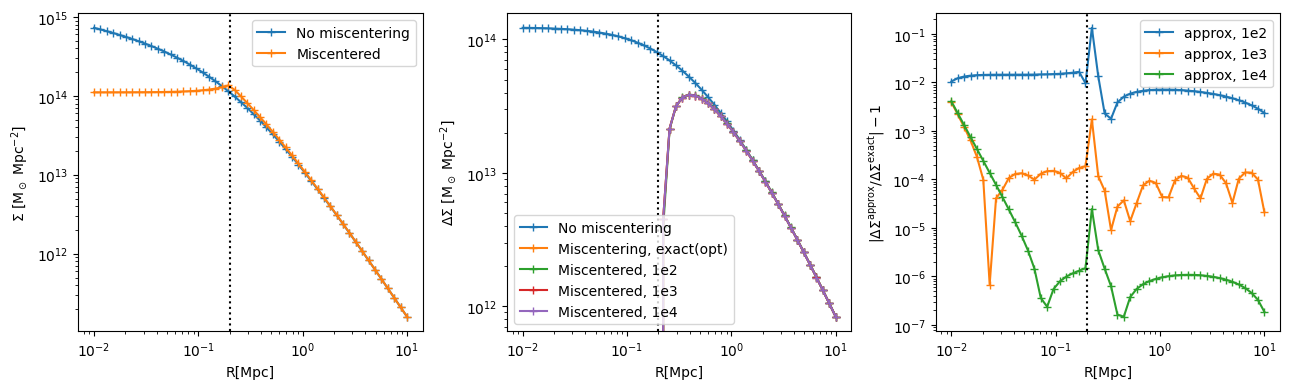

In [31]:
fig, axes = plt.subplots(ncols=3, figsize=(13,4))
axes[0].loglog(R_arr, Sigma, label='No miscentering', marker='+')
axes[0].loglog(R_arr, Sigma_mis, label='Miscentered', marker='+')
axes[0].axvline(Roff, c='k', ls=':')
axes[0].set_xlabel('R[Mpc]')
axes[0].set_ylabel(r'$\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[1].loglog(R_arr, DeltaSigma, label='No miscentering', marker='+')
#axes[1].loglog(R_arr, DeltaSigma_mis_exact, label='Miscentering, exact', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_exact_opt, label='Miscentering, exact(opt)', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_1e2, label='Miscentered, 1e2', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_1e3, label='Miscentered, 1e3', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_1e4, label='Miscentered, 1e4', marker='+')
#axes[1].loglog(R_arr, DeltaSigma_mis_1e5, label='Miscentered, 1e5', marker='+')
axes[1].axvline(Roff, c='k', ls=':')
axes[1].legend()
axes[1].set_xlabel('R[Mpc]')
axes[1].set_ylabel(r'$\Delta\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[2].loglog(R_arr, np.abs((DeltaSigma_mis_1e2/DeltaSigma_mis_exact_opt)-1), marker='+', label='approx, 1e2')
axes[2].loglog(R_arr, np.abs((DeltaSigma_mis_1e3/DeltaSigma_mis_exact_opt)-1), marker='+', label='approx, 1e3')
axes[2].loglog(R_arr, np.abs((DeltaSigma_mis_1e4/DeltaSigma_mis_exact_opt)-1), marker='+', label='approx, 1e4')
axes[2].axvline(Roff, c='k', ls=':')
axes[2].set_xlabel('R[Mpc]')
axes[2].set_ylabel(r'$|\Delta\Sigma^{\rm approx}/\Delta\Sigma^{\rm exact}|-1$')


axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()

# Stacked profiles

In [32]:
Roff = 0.2

In [33]:
def Roff_distrib(Roff, Rmis=0.2):
    return np.exp(-Roff/Rmis) * Roff/(Rmis*Rmis)

def integrand_Sigmastack_mean_exact(Rprime, Roff): 
    return Rprime * Sigma_stack_mis_exact(Rprime, Roff)

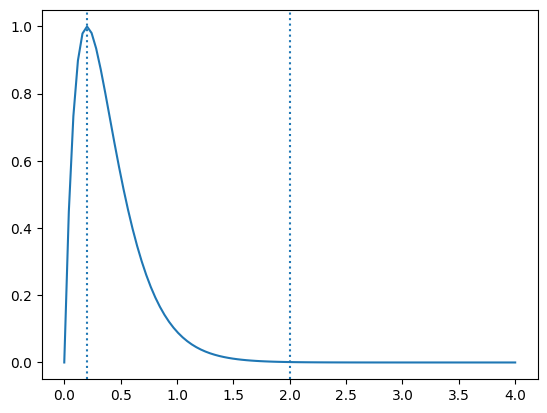

In [34]:
Roff_arr = np.linspace(0, 20*Roff, 100)
plt.plot(Roff_arr, Roff_distrib(Roff_arr, Rmis=Roff)/Roff_distrib(Roff, Rmis=Roff))
plt.axvline(Roff, linestyle=':')
plt.axvline(10.*Roff, linestyle=':')

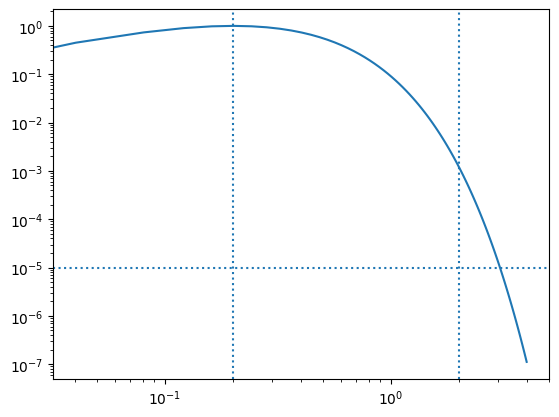

In [35]:
plt.loglog(Roff_arr, Roff_distrib(Roff_arr, Rmis=Roff)/Roff_distrib(Roff, Rmis=Roff))
plt.axvline(Roff, linestyle=':')
plt.axvline(10.*Roff, linestyle=':')
plt.axhline(1.e-5, linestyle=':')

In [36]:
R_arr_int = np.logspace(-5, 4, 100)

## Original implementation 
Exact calculation for Sigma + simpson integration for convolution with Roff distribution + approx trapezoid integration for Sigma mean.

In [37]:
def Sigma_mis_interp(R, Roff):
    Sigma_mis = Sigma_mis_exact(R_arr_int, Roff)
    f_sigmamis = interp1d(R_arr_int, Sigma_mis)
    #print(Sigma_mis)
    #print(f_sigmamis(R))
    return f_sigmamis(R)

In [47]:
def integrand_stack(Roff, R, Rmis):
    return Sigma_mis_interp(R, Roff) * Roff_distrib(Roff, Rmis)

def integrand_stack_tab(Roff_tab, R, Rmis):
    return np.array([Sigma_mis_interp(R, r) * Roff_distrib(r, Rmis) for r in Roff_tab])

def Sigma_stack_mis_exact(R_arr, Rmis=3.):
    return integrate.quad_vec(integrand_stack, 1.e-5, 1.e5, args=(R, Rmis))[0]

def Sigma_stack_mis_simps(R_arr, Rmis, Rinfty_scale=10, ngrid=100):
    Roff_tab = np.linspace(0.,Rmis*Rinfty_scale,ngrid)
    tab = integrand_stack_tab(Roff_tab, R_arr, Rmis)
    return integrate.simpson(tab, x=Roff_tab, axis=0)

In [48]:
%%time
Sigma_mis_stack_simps = Sigma_stack_mis_simps(R_arr, Rmis=Roff)

CPU times: user 9.19 s, sys: 272 ms, total: 9.46 s
Wall time: 10.3 s


In [40]:
def Sigma_mean_mis_stack_trap(R_arr, Rmis, ngrid=100, Rinfty_scale=10, ngrid_sigma=100):

    new_R_arr = np.logspace(np.log10(1.e-5), np.log10(R_arr.max()), ngrid)
    res = (2./new_R_arr**2) * integrate.cumulative_trapezoid(new_R_arr * Sigma_stack_mis_simps(new_R_arr, Rmis, Rinfty_scale=Rinfty_scale, ngrid=ngrid_sigma), new_R_arr, initial=0)

    f = interp1d(new_R_arr, res)
    return f(R_arr)

In [41]:
Roff=0.2
R_arr2 = np.logspace(-2, np.log10(20), 50)

Sigma = moo.eval_surface_density(R_arr2, z_cl)
Sigma_mis = Sigma_mis_exact(R_arr2, Roff)

In [42]:
DeltaSigma = moo.eval_excess_surface_density(R_arr2, z_cl)
DeltaSigma_mis = DS_mis_approx(R_arr2, Roff, regrid=1000)

In [49]:
%%time
Sigma_mis_stack = Sigma_stack_mis_simps(R_arr2, Rmis=Roff, Rinfty_scale=10, ngrid=1000)
Sigma_mean_stack_mis_trap = Sigma_mean_mis_stack_trap(R_arr2, Rmis=Roff, ngrid=1000, Rinfty_scale=10, ngrid_sigma=1000)
DeltaSigma_stack_mis = Sigma_mean_stack_mis_trap - Sigma_mis_stack

CPU times: user 2min 52s, sys: 4.23 s, total: 2min 57s
Wall time: 3min 3s


In [52]:
# tst

def DS_mis_interp(R,Roff,ngrid):
    new_R_arr = np.logspace(np.log10(1.e-5), np.log10(R_arr.max()), ngrid)

    ## Sigma
    Sigma_mis = Sigma_mis_exact(new_R_arr, Roff)
    f_sigma = interp1d(new_R_arr, Sigma_mis)

    ## Sigma mean
    Sigmamean_mis = (2./new_R_arr**2) * integrate.cumulative_trapezoid(new_R_arr * f_sigma(new_R_arr), new_R_arr, initial=0)
    f_sigmamean = interp1d(new_R_arr, Sigmamean_mis)

    return f_sigmamean(R_arr) - f_sigma(R_arr)


def DS_integrand_stack_tab(Roff_tab, R, Rmis, ngrid):
    return np.array([DS_mis_interp(R,r, ngrid) * Roff_distrib(r, Rmis) for r in Roff_tab])


def DS_stack_mis_tst(R_arr, Rmis, Rinfty_scale=10, ngrid=1000):
    Roff_tab = np.linspace(0.,Rmis*Rinfty_scale,ngrid)
    tab = DS_integrand_stack_tab(Roff_tab, R_arr, Rmis, ngrid)
    #tab = np.array([DS_mis_interp(R_arr, r, ngrid) * Roff_distrib(r, Rmis) for r in Roff_tab])
    return integrate.simpson(tab, x=Roff_tab, axis=0)

In [ ]:
%%time
Roff_tab = np.linspace(0.,6, 1000)
tab = DS_integrand_stack_tab(Roff_tab, R_arr2, Roff, 1000)
#DeltaSigma_stack_mis_tst = DS_stack_mis_tst(R_arr2, Roff)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
axes[0].loglog(R_arr2, Sigma, label='No miscentering', marker='+')
axes[0].loglog(R_arr2, Sigma_mis, label='Miscentered, single', marker='+')
axes[0].loglog(R_arr2, Sigma_mis_stack, label='Miscentered, stack', marker='+')
axes[0].axvline(Roff, c='k', ls=':')
axes[0].set_xlabel('R[Mpc]')
axes[0].set_ylabel(r'$\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[1].loglog(R_arr2, DeltaSigma, label='No miscentering', marker='+')
axes[1].loglog(R_arr2, DeltaSigma_mis, label='Miscentered, single, 1e3', marker='+')
axes[1].loglog(R_arr2, DeltaSigma_stack_mis, label='Miscentered, stack, 1.e3', marker='+')
axes[1].loglog(R_arr2, DeltaSigma_stack_mis_opt_1000, label='Miscentered, stack, opt', marker='+')
axes[1].axvline(Roff, c='k', ls=':')
axes[1].legend()
axes[1].set_xlabel('R[Mpc]')
axes[1].set_ylabel(r'$\Delta\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[0].legend()
axes[1].legend()

fig.tight_layout()

## With optimized Dsig + convolution (in prog)

In [ ]:
def integrand_DS_stack(Roff, R_arr, Rmis):
    return DS_mis_exact_opt_dbl(R_arr, Roff) * Roff_distrib(Roff, Rmis)

In [ ]:
def DS_stack_opt_exact(R_arr, Rmis, Rinfty_scale=10):
    return integrate.quad_vec(integrand_DS_stack, 0., Rmis*Rinfty_scale, args=(R_arr, Rmis))[0]

In [ ]:
%%time
#DeltaSigma_stack_mis_opt_exact = DS_stack_opt_exact(R_arr2, Roff)

In [ ]:
def integrand_DS_stack_tab(Roff_tab, R, Rmis):
    return np.array([DS_mis_exact_opt(R, r) * Roff_distrib(r, Rmis) for r in Roff_tab])

def DS_stack_opt_tab(R_arr, Rmis, Rinfty_scale=10, ngrid=1000):
    Roff_tab = np.linspace(0.,Rmis*Rinfty_scale,ngrid)
    #Roff_tab = np.logspace(-2,np.log(Rmis*Rinfty_scale),ngrid)
    tab = integrand_DS_stack_tab(Roff_tab, R_arr, Rmis)
    return integrate.simpson(tab, Roff_tab, axis=0)

In [ ]:
#%%time
#DeltaSigma_stack_mis_opt_20 = DS_stack_opt_tab(R_arr2, Roff, Rinfty_scale=10, ngrid=10)

In [ ]:
DeltaSigma_stack_mis_opt_10 =  DeltaSigma_stack_mis_opt_1000.copy()

In [ ]:
Roff